In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_spirals, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle, get_ece, get_ace
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
import timeit

### Visualize the data

<AxesSubplot: >

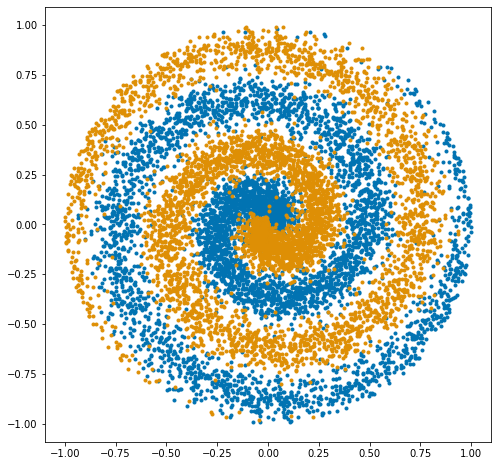

In [2]:
X, y = generate_spirals(10000)
plot_2dsim(X, y)

In [3]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [4]:
# network architecture [1000, 1000, 1000, 1000, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [5]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Metal device set to: Apple M1 Max


2023-09-02 01:32:58.281123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-02 01:32:58.281253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-02 01:32:58.483535: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-02 01:32:58.685923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 107: early stopping


### Calculate posteriors and likelihoods using KDN

In [6]:
df = {}

t_0 = timeit.default_timer()
model_kdn = kdn(network=nn)
model_kdn.fit(X, y, k=1e9)
t_1 = timeit.default_timer()

print(f"Elapsed time: {t_1-t_0} s")
#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)
posterior_kdn_geod, likelihoods_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(400,400)
posterior_kdn = posterior_kdn[:,0].reshape(400,400)
class1_likelihoods = likelihoods_kdn[:,0].reshape(400,400)
class2_likelihoods = likelihoods_kdn[:,1].reshape(400,400)

posterior_kdn_geod = posterior_kdn_geod[:,0].reshape(400,400)
class1_likelihoods_geod = likelihoods_kdn_geod[:,0].reshape(400,400)
class2_likelihoods_geod = likelihoods_kdn_geod[:,1].reshape(400,400)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods
df['posterior_kdn_geod'] = posterior_kdn_geod
df['likelihood_class1_geod'] = class1_likelihoods_geod
df['likelihood_class2_geod'] = class2_likelihoods_geod

Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 12.00s/it]


Elapsed time: 67.25484295799833 s
  87/5000 [..............................] - ETA: 8s

2023-09-02 01:35:57.912976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5000/5000 [==============================] - 9s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:14<00:00, 74.81s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:18<00:00, 87.71s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:24<00:00, 88.84s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:21<00:00, 88.39s/it]


In [7]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/spiral_pdf.csv")
proba_true = 0.5*np.ones((400, 400))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[100:300, 100:300] = 1 - tmp

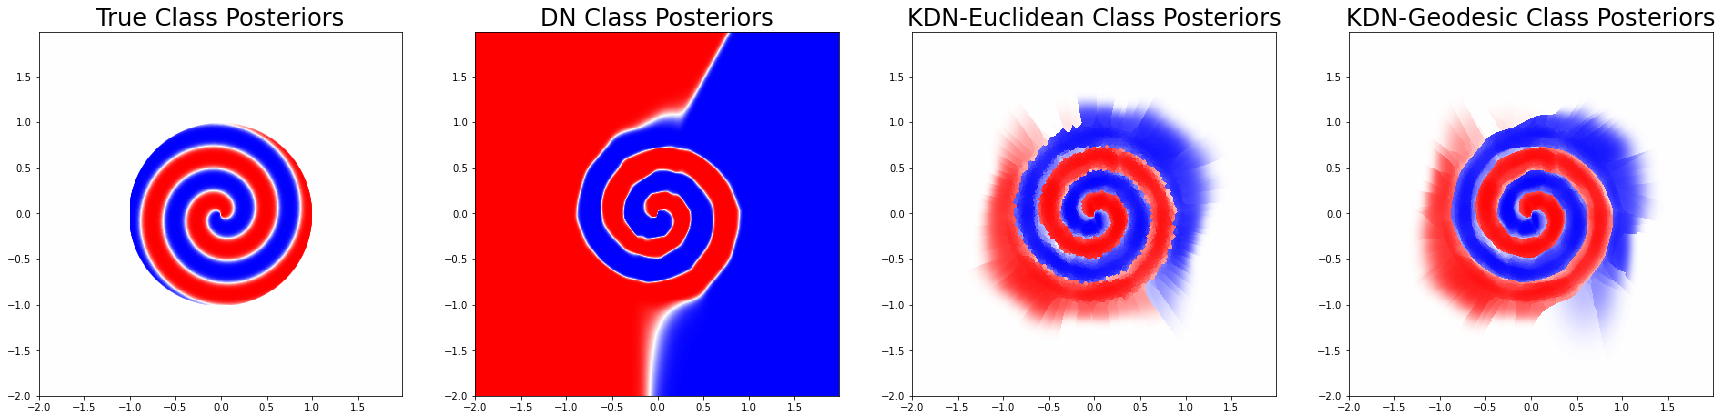

In [8]:
fig1, ax = plt.subplots(1, 4, figsize=(30, 150))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    1-posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    1-posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN-Euclidean Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")

ax2 = ax[3].imshow(
    1-posterior_kdn_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("KDN-Geodesic Class Posteriors", fontsize=24)
ax[3].set_aspect("equal")
plt.show()

### Visualize class likelihoods

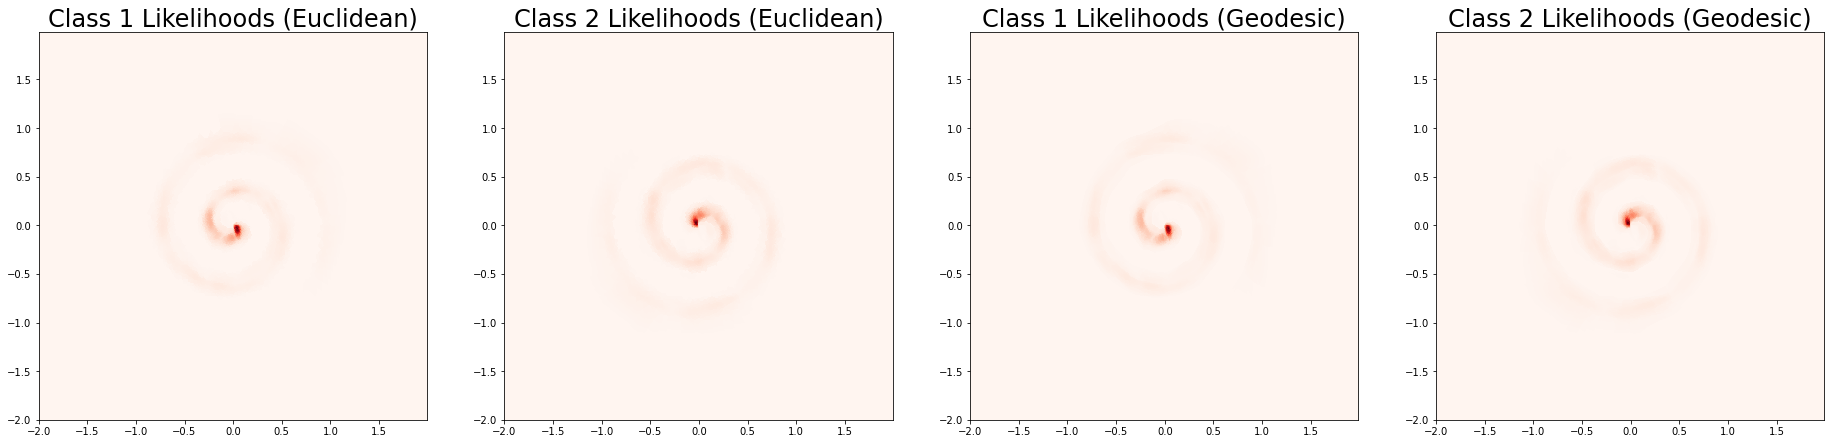

In [9]:
fig1, ax = plt.subplots(1, 4, figsize=(32, 8))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods (Euclidean)", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods (Euclidean)", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    class1_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("Class 1 Likelihoods (Geodesic)", fontsize=24)
ax[2].set_aspect("equal")

ax3 = ax[3].imshow(
    class2_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("Class 2 Likelihoods (Geodesic)", fontsize=24)
ax[3].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [10]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/spiral_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((true_posterior.ravel(), 1-true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_spirals(sample)
    X_test, y_test = generate_spirals(n_test)

    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e9)

    error_kdn = 1 - np.mean(model_kdn.predict(X_test)==y_test)
    error_kdn_geod = 1 - np.mean(model_kdn.predict(X_test, distance='Geodesic')==y_test)
    error_dn = 1 - np.mean(np.argmax(model_kdn.network.predict(X_test),axis=1)==y_test)
    
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic')
    proba_dn = model_kdn.network.predict(grid_samples)
    
    hellinger_dis_kdn = hellinger(true_posterior, proba_kdn)
    hellinger_dis_kdn_geod = hellinger(true_posterior, proba_kdn_geod)
    hellinger_dis_dn = hellinger(true_posterior, proba_dn)
    
    
    return error_kdn, error_kdn_geod, error_dn, hellinger_dis_kdn, hellinger_dis_kdn_geod, hellinger_dis_dn

def experiment_out(in_sample, r, n_test):
    mmcOut_dn = np.zeros(len(r),dtype=float)
    mmcOut_kdn = np.zeros(len(r),dtype=float)
    mmcOut_kdn_geod = np.zeros(len(r),dtype=float)
    
    X, y = generate_spirals(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e3)
    
    for ii, r_ in enumerate(r):
        X_ood = sample_unifrom_circle(n=n_test, r=r_)
        mmcOut_dn[ii] = np.mean(np.max(
            model_kdn.network.predict(X_ood), axis=1
            )
        )
        mmcOut_kdn[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
        mmcOut_kdn_geod[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood, distance='Geodesic'), axis=1))
    
    return mmcOut_kdn, mmcOut_kdn_geod, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_kdn_geod_med = []
error_kdn_geod_25 = []
error_kdn_geod_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_kdn_geod_med = []
hellinger_kdn_geod_25 = []
hellinger_kdn_geod_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []


mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_kdn_geod_med = []
mmcOut_kdn_geod_25 = []
mmcOut_kdn_geod_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []


#### do out-of-distribution results ####
r = np.arange(0,10.5,.5)
mmcOut_kdn = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_kdn_geod = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_dn = np.zeros((len(r),mc_reps), dtype=float)

for rep in range(mc_reps):
    mmcOut_kdn[:,rep], mmcOut_kdn_geod[:,rep], mmcOut_dn[:,rep] = experiment_out(1000, r, n_test)
    
    
mmcOut_kdn_med = np.median(mmcOut_kdn, axis=1)
mmcOut_kdn_25 = np.quantile(mmcOut_kdn, [0.25], axis=1)
mmcOut_kdn_75 = np.quantile(mmcOut_kdn, [0.75], axis=1)

mmcOut_kdn_geod_med = np.median(mmcOut_kdn_geod, axis=1)
mmcOut_kdn_geod_25 = np.quantile(mmcOut_kdn_geod, [0.25], axis=1)
mmcOut_kdn_geod_75 = np.quantile(mmcOut_kdn_geod, [0.75], axis=1)

mmcOut_dn_med = np.median(mmcOut_dn, axis=1)
mmcOut_dn_25 = np.quantile(mmcOut_dn, [0.25], axis=1)
mmcOut_dn_75 = np.quantile(mmcOut_dn, [0.75], axis=1)
    
        
#### do in-distribution results ####
for sample in sample_size:
    err_kdn = []
    err_kdn_geod = []
    err_dn = []
    hellinger_kdn = []
    hellinger_kdn_geod = []
    hellinger_dn = []
    
    for ii in range(mc_reps):
        a,b,c,d,e,f = experiment_in(sample, n_test, true_posterior) 
        
        err_kdn.append(a)
        err_kdn_geod.append(b)
        err_dn.append(c)
        hellinger_kdn.append(d)
        hellinger_kdn_geod.append(e)
        hellinger_dn.append(f)
        

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )
    
    error_kdn_geod_med.append(
        np.median(err_kdn_geod)
    )
    error_kdn_geod_25.append(
        np.quantile(err_kdn_geod, [0.25])[0]
    )
    error_kdn_geod_75.append(
        np.quantile(err_kdn_geod, [0.75])[0]
    )
    
    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )
    
    hellinger_kdn_geod_med.append(
        np.median(hellinger_kdn_geod)
    )
    hellinger_kdn_geod_25.append(
        np.quantile(hellinger_kdn_geod, [0.25])[0]
    )
    hellinger_kdn_geod_75.append(
        np.quantile(hellinger_kdn_geod, [0.75])[0]
    )
    
    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )
    
    

df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_kdn_geod_med'] = error_kdn_geod_med
df['error_kdn_geod_25'] = error_kdn_geod_25
df['error_kdn_geod_75'] = error_kdn_geod_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_kdn_geod_med'] = hellinger_kdn_geod_med
df['hellinger_kdn_geod_25'] = hellinger_kdn_geod_25
df['hellinger_kdn_geod_75'] = hellinger_kdn_geod_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25
df['mmcOut_kdn_75'] = mmcOut_kdn_75

df['mmcOut_kdn_geod_med'] = mmcOut_kdn_geod_med
df['mmcOut_kdn_geod_25'] = mmcOut_kdn_geod_25
df['mmcOut_kdn_geod_75'] = mmcOut_kdn_geod_75

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25
df['mmcOut_dn_75'] = mmcOut_dn_75

2023-09-02 02:04:55.282554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 87: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:05:05.905748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]
2023-09-02 02:05:24.365337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 78: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:05:33.856256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]
2023-09-02 02:05:52.252621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 73: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:06:01.000807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]
2023-09-02 02:06:18.298941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 77: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:06:27.387611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]
2023-09-02 02:06:44.943345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 83: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:06:54.803932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]
2023-09-02 02:07:12.222378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 97: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:07:23.399334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]
2023-09-02 02:07:40.826421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:07:48.085876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]
2023-09-02 02:08:05.761668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:08:13.870990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]
2023-09-02 02:08:31.462388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:08:39.290947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]
2023-09-02 02:08:57.406737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:09:03.857228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]
2023-09-02 02:09:22.487043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 205.20it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 66.17it/s]
2023-09-02 02:09:24.509133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:09:31.045650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 207.88it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.79it/s]

32/32 [==============================] - 0s 2ms/step



2023-09-02 02:09:33.274318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:09:39.648879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 252.26it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 65.44it/s]
2023-09-02 02:09:41.570291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:09:48.001337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 295.21it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 65.56it/s]
2023-09-02 02:09:49.934514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:09:56.393108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 286.47it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 67.86it/s]
2023-09-02 02:09:58.323115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:10:04.728069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 283.61it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 67.50it/s]
2023-09-02 02:10:06.672864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:10:13.056455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 285.40it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.19it/s]
2023-09-02 02:10:14.990202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:10:21.384641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 295.49it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 70.61it/s]
2023-09-02 02:10:23.330412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:10:29.712975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 269.24it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.27it/s]
2023-09-02 02:10:31.665381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:10:38.029866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 197: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 271.62it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.37it/s]
2023-09-02 02:10:39.940287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:10:46.270522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 91: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 158.30it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.97it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:10:48.194419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:10:55.596323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 145: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 150.39it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.91it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:10:58.290458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:11:05.740016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 166.85it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.74it/s]
2023-09-02 02:11:09.275269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:11:17.033704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 137: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 140.87it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.25it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:11:19.660087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:11:27.211152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 140.93it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.82it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:11:30.705331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:11:38.146612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 106: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 132.59it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.40it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:11:40.303271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:11:47.740356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 119.86it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.66it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:11:51.282775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:11:58.862524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 137.70it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.65it/s]
2023-09-02 02:12:02.411113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:12:09.907352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 104: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 144.40it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.65it/s]
2023-09-02 02:12:12.088995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:12:19.582709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 134: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 161.94it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.37it/s]


 1/32 [..............................] - ETA: 1s

2023-09-02 02:12:22.188377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:12:29.658966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 102: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.08it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.30it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:12:36.470972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:12:52.451640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.72it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-02 02:12:55.873628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.18s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:13:11.565943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 91: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.69it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.00it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-02 02:13:17.697363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.18s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:13:33.368535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.17it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.57it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:13:38.181156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.20s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:13:54.291502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 74: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.68it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.58it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:13:59.641667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:14:15.696071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 68: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.41it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.72it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-02 02:14:20.710621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:14:36.534247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.78it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.67it/s]
2023-09-02 02:14:40.435962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:14:56.408333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 109: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.98it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.69it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-02 02:15:03.636643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:15:19.768923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.21it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-02 02:15:24.609776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:15:40.546275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 93: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.13it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.51it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:15:46.892475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:16:02.958314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-02 02:16:10.492694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.33s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:16:37.033101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 68: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-02 02:16:46.534914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.43s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:17:13.548796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 62: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-02 02:17:22.485367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.39s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:17:49.658344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-02 02:17:56.731872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.36s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:18:23.383523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 92: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-02 02:18:35.414544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.42s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:19:02.399393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-02 02:19:11.834006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.30s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:19:38.344277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-02 02:19:49.278957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.24s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:20:15.346927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 87: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-02 02:20:26.855221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.42s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:20:53.771403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 68: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-02 02:21:03.160387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.34s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:21:29.770385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-02 02:21:38.342428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.29s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:22:04.664803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 54: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.82s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:22:52.717622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.19s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:25:19.437891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.81s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:26:13.917516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.17s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:28:35.599310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.83s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.57it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:29:25.379360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.95s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:31:45.896932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.86s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:32:24.633337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.92s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:34:44.983331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.80s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.57it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:35:25.745544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.61s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:37:44.597920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 61: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.81s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]

 1/32 [..............................] - ETA: 2s


2023-09-02 02:38:35.936775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.13s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:40:57.396961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 69: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.83s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.57it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:41:52.994287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.13s/it]


1250/1250 [==============================] - 3s 2ms/step


2023-09-02 02:44:14.945048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.84s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]

 1/32 [..............................] - ETA: 2s


2023-09-02 02:44:57.353143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.22s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:47:14.276011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 95: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.84s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:48:23.876055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.88s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:50:49.009489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.77s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.57it/s]

 1/32 [..............................] - ETA: 1s


2023-09-02 02:51:23.864802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.99s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 02:53:44.625123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.16s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]

32/32 [==============================] - 0s 3ms/step



2023-09-02 02:56:02.828611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:32<00:00, 78.56s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 03:02:42.768428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 74: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.81s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]

28/32 [=========================>....] - ETA: 0s


2023-09-02 03:05:11.217430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:35<00:00, 79.14s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 03:11:54.113431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.02s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


23/32 [====================>.........] - ETA: 0s

2023-09-02 03:13:54.747809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:28<00:00, 77.61s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 03:20:30.019867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.94s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


32/32 [==============================] - 0s 3ms/step


2023-09-02 03:22:39.027860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:26<00:00, 77.26s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 03:29:12.408891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:58<00:00, 11.75s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]
2023-09-02 03:31:16.021779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:28<00:00, 77.73s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 03:37:52.010992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 89: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:57<00:00, 11.57s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]
2023-09-02 03:40:32.186079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:32<00:00, 78.41s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 03:47:11.294868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 60: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:58<00:00, 11.69s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.13s/it]
2023-09-02 03:49:23.611026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:33<00:00, 78.75s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 03:56:04.524058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.02s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]


23/32 [====================>.........] - ETA: 0s

2023-09-02 03:58:17.588668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:30<00:00, 78.16s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 04:04:55.538684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 20: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:57<00:00, 11.58s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


23/32 [====================>.........] - ETA: 0s

2023-09-02 04:06:28.281333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:27<00:00, 77.54s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 04:13:03.218263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.89s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


25/32 [======================>.......] - ETA: 0s

2023-09-02 04:15:06.268815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:31<00:00, 78.34s/it]


1250/1250 [==============================] - 2s 2ms/step


### Save the result

In [11]:
import pickle
filename = 'results/spiral.pickle'

with open(filename, 'wb') as f:
    pickle.dump(df,f)

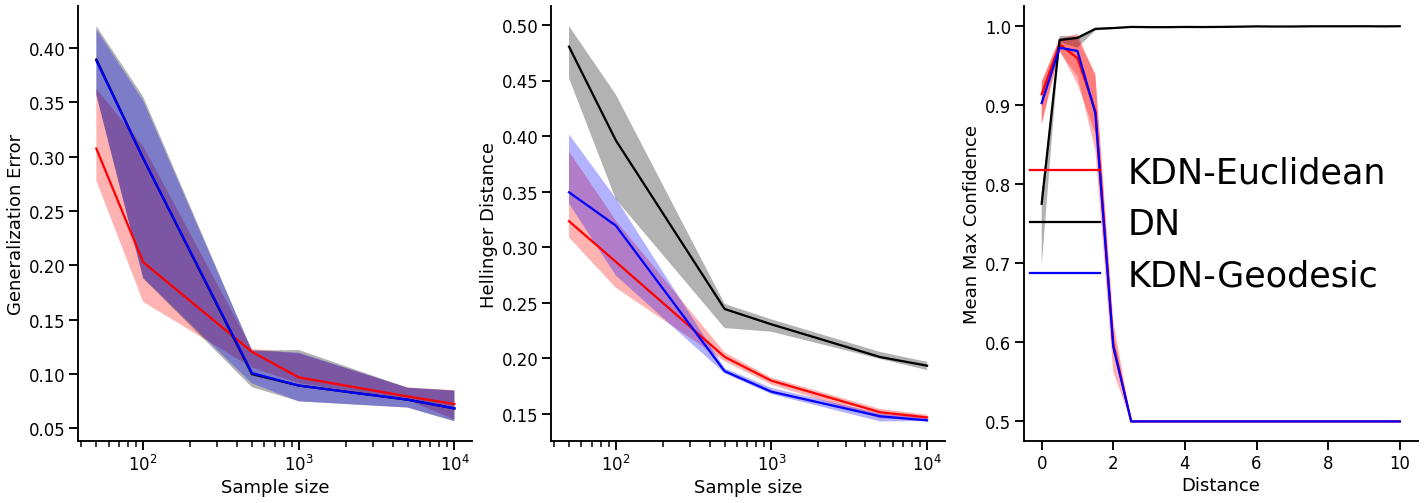

In [12]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,3, figsize=(24,8))


ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN-Euclidean')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')
ax[0].plot(sample_size, df['error_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)
ax[0].fill_between(sample_size, df['error_kdn_geod_25'], df['error_kdn_geod_75'], facecolor='b', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN-Euclidean')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')
ax[1].plot(sample_size, df['hellinger_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_kdn_geod_25'], df['hellinger_kdn_geod_75'], facecolor='b', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[2].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN-Euclidean')
ax[2].plot(r, df['mmcOut_dn_med'], c="k", label='DN')
ax[2].plot(r, df['mmcOut_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[2].fill_between(r, df['mmcOut_kdn_25'].ravel(), df['mmcOut_kdn_75'].ravel(), facecolor='r', alpha=.3)
ax[2].fill_between(r, df['mmcOut_dn_25'].ravel(), df['mmcOut_dn_75'].ravel(), facecolor='k', alpha=.3)
ax[2].fill_between(r, df['mmcOut_kdn_geod_25'].ravel(), df['mmcOut_kdn_geod_75'].ravel(), facecolor='r', alpha=.3)

#ax[3].set_xscale('log')
ax[2].set_xlabel('Distance')
ax[2].set_ylabel('Mean Max Confidence')

ax[2].legend(fontsize=35, frameon=False)

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)

## Control Experiment for determining the Bin size for ECE

In [42]:
kdn_ece = []
kdn_helinger = []
dn_ece = []
dn_helinger = []
n_test = 50000
sample_size = [50, 100, 500, 1000, 5000, 10000]
tp_df = pd.read_csv("../true_posterior/spiral_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((1-true_posterior.ravel(), true_posterior.ravel())).T

for sample in sample_size:
    print("Doing sample ", sample)
    X, y = generate_spirals(sample)
    X_test, y_test = generate_spirals(n_test)
    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e9)
    
    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    
    proba_dn = model_kdn.network.predict(X_test)
    proba_kdn = model_kdn.predict_proba(X_test)
    proba_kdn_grid = model_kdn.predict_proba(grid_samples)
    proba_dn_grid = model_kdn.network.predict(grid_samples)
    
    kdn_helinger.append(hellinger(1-true_posterior, proba_kdn_grid))
    dn_helinger.append(hellinger(1-true_posterior, proba_dn_grid))
    
    kdn_ece.append(ece(y_test, proba_kdn))
    dn_ece.append(ece(y_test, proba_dn))

Doing sample  50


2023-08-22 13:29:59.086666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  27/1563 [..............................] - ETA: 6s

2023-08-22 13:30:01.912825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 4s 3ms/step
Doing sample  100


2023-08-22 13:30:14.833080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 116: early stopping
  27/1563 [..............................] - ETA: 6s

2023-08-22 13:30:18.174972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 5s 4ms/step
Doing sample  500


2023-08-22 13:30:33.813312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 61: early stopping
  27/1563 [..............................] - ETA: 5s

2023-08-22 13:30:41.717366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 4s 3ms/step
Doing sample  1000


2023-08-22 13:31:03.453431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 98: early stopping
  26/1563 [..............................] - ETA: 6s

2023-08-22 13:31:28.578050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 4s 3ms/step
Doing sample  5000


2023-08-22 13:31:59.538949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

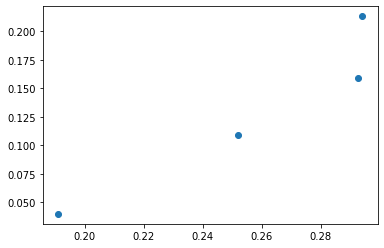

In [43]:
plt.scatter(kdn_helinger, kdn_ece)

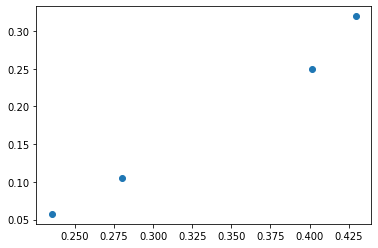

In [44]:
plt.scatter(dn_helinger, dn_ece)

In [45]:
kdn_helinger

[0.29245767655113497,
 0.29408014009787137,
 0.25177717996891236,
 0.19095257585231704]

In [46]:
kdn_ece

[0.15911268059124886,
 0.21322929100790955,
 0.10934659180310811,
 0.039694537898864846]

In [47]:
dn_ece

[0.24950677852153783,
 0.3196567744231224,
 0.10506466458082199,
 0.05752559754490851]

In [39]:
def bin_data(y, n_bins):
    """
    Partitions the data into ordered bins based on
    the probabilities. Returns the binned indices.
    """
    edges = np.linspace(0, 1, n_bins)
    bin_idx = np.digitize(y, edges, right=True)
    binned_idx = [np.where(bin_idx == i)[0] for i in range(n_bins)]

    return binned_idx


def bin_stats(y_true, y_proba, bin_idx):
    # mean accuracy within each bin
    bin_acc = [
        np.equal(np.argmax(y_proba[idx], axis=1),
                 y_true[idx]).mean() if len(idx) > 0 else 0
        for idx in bin_idx
    ]
    # mean confidence of prediction within each bin
    bin_conf = [
        np.mean(np.max(y_proba[idx], axis=1)) if len(idx) > 0 else 0
        for idx in bin_idx
    ]

    return np.asarray(bin_acc), np.asarray(bin_conf)


def ece(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    n = len(y_true)

    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    bin_sizes = [len(idx) for idx in bin_idx]

    ece = np.sum(np.abs(bin_acc - bin_conf) * np.asarray(bin_sizes)) / n

    return ece


In [40]:
ece(y_test, proba_kdn)

0.020081682632529827

In [41]:
ece(y_test, proba_dn)

0.0672325232374668